In [1]:
pip install deep-pipe

     |████████████████████████████████| 74 kB 1.2 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 1.7 MB 46.0 MB/s 
     |████████████████████████████████| 97 kB 4.0 MB/s 
     |████████████████████████████████| 180 kB 68.9 MB/s 
     |████████████████████████████████| 142 kB 60.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for deep-pipe: filename=deep_pipe-0.1.1-py3-none-any.whl size=102401 sha256=0fc82593d1aa7bb4b38406f97358887d5c90b2565ea40e7e65345ccb793fb43a
  Stored in directory: /root/.cache/pip/wheels/e9/d1/b3/9e1a4c95d9c2e162c4954c9088026ef3c0e0d539164e124f58
  Created wheel for pdp: filename=pdp-0.3.0-py3-none-any.whl size=6616 sha256=68bc8ef4f2341abe5fb7605bdd799b6568964dc412d3e31f41d1d6347a6fdd47
  Stored in directory: /root/.cache/pip/wheels/86/3f/21/790268989f0e594527d3b781d80e150499eb918f8c88c1509a
  Created wheel for lazycon: filename=lazycon-0.3.1-py3-none-any.whl size=18969 sha256=5

In [2]:
pip install tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from dpipe.layers.resblock import ResBlock2d
from dpipe.layers.conv import PreActivation2d
import copy
import matplotlib.pyplot as plt
from statistics import mean
torch.autograd.set_detect_anomaly(True)
from tqdm import tqdm_notebook as tqdm
from statistics import mean 


In [5]:
import os
import random
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import string
from sklearn.preprocessing import MinMaxScaler
import torch
import nibabel as nib
from torch.utils.data import Dataset
from torch.utils.data import random_split
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [6]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from google.colab import drive
drive.mount('/content/gdrive') #, force_remount = True

cpu
Mounted at /content/gdrive


In [8]:
!cp -r /content/gdrive/MyDrive/VMIA_Lab_Data/surface_distance/ .

import surface_distance.surface_distance.metrics as surf_dst

# MODELS

### UNet Model

In [9]:
class UNet2D(nn.Module):
    def __init__(self, n_chans_in, n_chans_out, kernel_size=3, padding=1, pooling_size=2, n_filters_init=8,
                 dropout=False, p=0.1):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.pooling_size = pooling_size
        n = n_filters_init
        if dropout:
            dropout_layer = nn.Dropout(p)
        else:
            dropout_layer = nn.Identity()

        self.init_path = nn.Sequential(
            nn.Conv2d(n_chans_in, n, self.kernel_size, padding=self.padding, bias=False),
            nn.ReLU(),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut0 = nn.Conv2d(n, n, 1)

        self.down1 = nn.Sequential(
            nn.BatchNorm2d(n),
            nn.Conv2d(n, n * 2, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut1 = nn.Conv2d(n * 2, n * 2, 1)

        self.down2 = nn.Sequential(
            nn.BatchNorm2d(n * 2),
            nn.Conv2d(n * 2, n * 4, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut2 = nn.Conv2d(n * 4, n * 4, 1)

        self.down3 = nn.Sequential(
            nn.BatchNorm2d(n * 4),
            nn.Conv2d(n * 4, n * 8, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            dropout_layer
        )

        self.up3 = nn.Sequential(
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 8),
            nn.ConvTranspose2d(n * 8, n * 4, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.up2 = nn.Sequential(
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 4),
            nn.ConvTranspose2d(n * 4, n * 2, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.up1 = nn.Sequential(
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 2),
            nn.ConvTranspose2d(n * 2, n, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.out_path = nn.Sequential(
            ResBlock2d(n, n, kernel_size=1),
            PreActivation2d(n, n_chans_out, kernel_size=1),
            nn.BatchNorm2d(n_chans_out)
        )

    def forward(self, x):
        x0 = self.init_path(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)

        x2_up = self.up3(x3)
        x1_up = self.up2(x2_up + self.shortcut2(x2))
        x0_up = self.up1(x1_up + self.shortcut1(x1))
        x_out = self.out_path(x0_up + self.shortcut0(x0))

        return F.sigmoid(x_out), x3

### Disc Feature

In [10]:
  class Disc_Feature(nn.Module):
    def __init__(self, kernel_size=3, n_filters_init=8):
        super(Disc_Feature, self).__init__()
        n = n_filters_init

        self.conv = nn.Sequential(
            nn.Conv2d(n * 8, n * 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(n*16),
            nn.ReLU(),
            nn.Conv2d(n * 16, n * 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(n*32),
            nn.ReLU(),
            nn.Conv2d(n * 32, n * 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(n*64),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.flat_map_dim = self.dummy_forward()
        
        self.fc = nn.Sequential(
        nn.Linear(self.flat_map_dim, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 1)
        )

        self.sigmoid = nn.Sigmoid()

    def dummy_forward(self):
        dummy_x = torch.rand(1, 64, 36, 36)
        feature_map= self.conv(dummy_x)
        flat_map_dim = feature_map.view(1, -1).shape[-1]
        return flat_map_dim

    def forward(self, x):

        feature_map = self.conv(x)
        
        batch_size = feature_map.shape[0]

        out = self.fc(feature_map.view(batch_size,-1))

        return self.sigmoid(out)

x = torch.rand(8, 64, 36, 36)
model = Disc_Feature()
print(model(x))
print(model(x).shape)

tensor([[0.3941],
        [0.4161],
        [0.4633],
        [0.2976],
        [0.1796],
        [0.5149],
        [0.5090],
        [0.3691]], grad_fn=<SigmoidBackward0>)
torch.Size([8, 1])


### Disc Entropy

In [11]:
class Disc_Entropy(nn.Module):
  def __init__(self, kernel_size = 3, n_filters_init = 1):
    super(Disc_Entropy, self).__init__()
    n = n_filters_init

    self.conv = nn.Sequential(
        nn.Conv2d( 1 , 32, stride=2, kernel_size=3),
        #nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d( 32, 64 , stride=2, kernel_size=3),
        #nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d( 64, 128, stride=2, kernel_size=3),
        #nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 256, stride=2, kernel_size=3),
        #nn.BatchNorm2d( 256),
        nn.ReLU(),
        nn.Conv2d(256, 512, stride=2, kernel_size=3),
        #nn.BatchNorm2d( 512),
        nn.ReLU(),
        #nn.Dropout(0.25)
    )

    self.flat_map_dim = 512*8*8 

    self.fc = nn.Sequential(
        nn.Linear(self.flat_map_dim, 512),
        #nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 64),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 1)
        #nn.Dropout(0.5),    
    )

    self.sigmoid = nn.Sigmoid()
   

  def forward(self, x):

    x1 = self.conv(x) # (B, 512, 8, 8)

    batch_size = x1.shape[0]
    
    x2 = self.fc( x1.view(batch_size,-1) )
  
    return self.sigmoid(x2)

x = torch.rand(8, 1, 288, 288)
model = Disc_Entropy()
print(model(x))
print(model(x).shape)

tensor([[0.5073],
        [0.5071],
        [0.5071],
        [0.5072],
        [0.5071],
        [0.5072],
        [0.5073],
        [0.5073]], grad_fn=<SigmoidBackward0>)
torch.Size([8, 1])


# Dataset

In [12]:
import time
class Disc_Train_PreprocessedData(Dataset):
  def __init__(self, mode = 'train', high_ram = False): 

    src_size = 4000 #8280
    trg_size = 4000 #7560

    self.labels = torch.cat([ torch.ones(src_size), torch.zeros(trg_size) ])

    self.images = torch.from_numpy(np.concatenate(
                    [np.load('/content/gdrive/MyDrive/GE/ge3_'+ mode + '_original_images.npy')[:src_size,:,:],
                    np.load('/content/gdrive/MyDrive/Philips/philips3_'+ mode + '_original_images.npy')[:trg_size,:,:] ],
                    axis = 0)).float()

    self.masks = torch.from_numpy( np.concatenate(
                    [np.load('/content/gdrive/MyDrive/GE/ge3_'+ mode + '_mask_images.npy')[:src_size,:,:],
                    np.load('/content/gdrive/MyDrive/Philips/philips3_'+ mode + '_mask_images.npy')[:trg_size,:,:] ]
                    , axis = 0)).float()

    if high_ram == True:
      indexes = list(range( src_size + trg_size ))
      random.shuffle(indexes)

      self.labels = self.labels[indexes]
      self.images = self.images[indexes,:,:]
      self.masks = self.masks[indexes,:,:]

    print(self.images.shape)
    print(self.masks.shape)
    print(self.labels.shape)

    
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):

    original_batch = self.images[idx]
    mask_batch = self.masks[idx]
    labels = self.labels[idx]

    return original_batch, mask_batch, labels 


In [14]:
class Disc_Val_PreprocessedData(Dataset):
  def __init__(self, mode = 'val', domain = 'ge'): 
    
    if domain == 'ge':
      path = '/content/gdrive/MyDrive/GE/'

    elif domain == 'philips':
      path = '/content/gdrive/MyDrive/Philips/'

    self.images = torch.from_numpy(np.load(path + domain + '3_' + mode + '_original_images.npy')).float()
    self.masks = torch.from_numpy(np.load(path + domain + '3_' + mode + '_mask_images.npy')).float()
    
    if domain == 'ge':
      self.labels = torch.ones(len(self.images))
    elif domain == 'philips':
      self.labels = torch.zeros(len(self.images))
    
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):

    original_batch = self.images[idx]
    mask_batch = self.masks[idx]
    labels = self.labels[idx]
    
    return original_batch, mask_batch, labels 


In [15]:
batch_size = 16

train_data = Disc_Train_PreprocessedData(mode ='train' , high_ram = False)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True ,num_workers = 0)

print(len(train_data))
print(train_data.images.shape)
print(train_data.labels.shape)

###################################

torch.Size([8000, 288, 288])
torch.Size([8000, 288, 288])
torch.Size([8000])
8000
torch.Size([8000, 288, 288])
torch.Size([8000])


In [16]:
batch_size = 16

src_val_data = Disc_Val_PreprocessedData(mode ='val', domain = 'ge' )
src_val_loader = torch.utils.data.DataLoader(dataset = src_val_data, batch_size = batch_size, shuffle = False,num_workers = 0)

trg_val_data = Disc_Val_PreprocessedData(mode ='val', domain = 'philips' )
trg_val_loader = torch.utils.data.DataLoader(dataset = trg_val_data, batch_size = batch_size, shuffle = False,num_workers = 0)

print(len(src_val_data), len(trg_val_data))
print(src_val_data.images.shape, trg_val_data.images.shape)
print(src_val_data.labels.shape, trg_val_data.labels.shape)

2152 1980
torch.Size([2152, 288, 288]) torch.Size([1980, 288, 288])
torch.Size([2152]) torch.Size([1980])


# Loss

In [17]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.0000001):
      
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()  
                                 
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE #BCE, dice_loss

In [18]:
@torch.no_grad()
def Dice_Score(inputs, targets, smooth=0.0000001):
    # flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()

    dice_score = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

    return dice_score.detach().item()  

In [19]:
@torch.no_grad()
def Volumetric_Dice_Score(path, filename, segmenter):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # READ IMG AND GET PREDS
    #img = nib.load(path + 'Original/' + filename).get_fdata()
    segmenter.eval()

    img = nib.load(path + 'Original/' + filename).get_fdata()
    img = img/img.max()
    max_pad = 288
    pad_size = int((max_pad - img.shape[2])/2)
    img = np.pad(img, pad_width = ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode =  'constant', constant_values = 0)


    batch_size = 1
    out,_ = segmenter(torch.from_numpy( img[0:0 + batch_size,:,:]).unsqueeze(dim = 1).float().to(device))
    start_idx = batch_size

    for i in tqdm(range( int(img.shape[0]/batch_size) - 1)):
      out1,_ = segmenter(torch.from_numpy( img[start_idx: start_idx+ batch_size,:,:]).unsqueeze(dim = 1).float().to(device))
      out = torch.cat([out, out1], dim = 0)
      start_idx += batch_size
    
    pred = torch.where(out > 0.5, 1, 0)

    # READ MASK 
    mask_filename = filename.split(".nii")[0] + "_ss.nii.gz"
    mask = torch.from_numpy(nib.load(path + 'Silver-standard/' + mask_filename).get_fdata())
    mask = np.pad(mask, pad_width = ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode =  'constant', constant_values = 0)

    mask_bool = mask.astype(bool)
    pred_bool = pred.squeeze().detach().to('cpu').numpy().astype(bool)

    # GET SCORE
    score = surf_dst.compute_dice_coefficient( mask_bool, pred_bool)

    sds = surf_dst.compute_surface_distances( mask_bool, pred_bool, [1,1,1])
    asd = surf_dst.compute_average_surface_distance(sds)
    sdat = surf_dst.compute_surface_dice_at_tolerance(sds, 1)    
    hd = surf_dst.compute_robust_hausdorff(sds, 95)

    print(filename,"Surface Dice:",score,"| SD at tol:", sdat,"| HD:", hd)

    return score, sdat, hd

@torch.no_grad()         
def Eval_Vol_Dice(domain, mode, segmenter, val_stats, curr_epoch):

    dice_scores = []
    sdat_scores = []
    hd_scores = []

    base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/data/'

    with open(base_path + 'volume_path_dict.pkl', 'rb') as handle:
      volume_path_dict = pickle.load(handle)

    file_list = volume_path_dict[str(domain) + '_' + str(mode)]

    for filename in tqdm(file_list):
      
      score, sdat, hd = Volumetric_Dice_Score(base_path, filename, segmenter)
      dice_scores.append( score )
      sdat_scores.append( sdat )
      hd_scores.append( hd )

    if domain == 'ge':
      domain_type = 'src'
    elif domain == 'philips':
      domain_type = 'trg'
    val_stats[domain_type + '_val_vol_dice'][curr_epoch] = dice_scores
    val_stats[domain_type + '_val_vol_sdat'][curr_epoch] = sdat_scores
    val_stats[domain_type + '_val_vol_hd'][curr_epoch] = hd_scores

    val_vol_dice = mean(dice_scores)
    val_vol_sdat = mean(sdat_scores)
    val_vol_hd = mean(hd_scores)
    
    print()
    print(domain,'vol metrics for epoch',curr_epoch)
    print('AVG VOLUMETRIC DICE :',val_vol_dice,"| SD AT TOL:", val_vol_sdat,"| HD:", val_vol_hd,'#########')


    return val_stats

# Training (2 opts)

In [20]:
def plotting( original, mask, pred):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_size_inches(6, 8, forward=True)
  fig.set_dpi(120)
  fig.tight_layout()
  ax1.imshow(original[0][0], cmap = 'gray')
  ax2.imshow(mask[0][0], cmap = 'gray')
  ax3.imshow(pred[0][0], cmap = 'gray')
  ax1.set_title('original')
  ax2.set_title('mask')
  ax3.set_title('pred')
  #plt.savefig(path + str(current_epoch) + '_' + str(batch_idx))
  plt.pause(0.00001)

In [21]:
@torch.no_grad()
def validation(curr_epoch, segmenter, discriminator, val_loader, domain, val_stats):
    segmenter.eval()
    discriminator.eval()

    seg_loss = DiceBCELoss().to(device) 
    disc_loss = torch.nn.BCELoss().to(device)
    adv_loss = torch.nn.BCELoss().to(device)

    dice_score = []

    comb_hist = []; seg_hist = []; disc_hist = []; adv_hist = [];
    adv_correct = 0 ; adv_total = 0; disc_correct = 0; disc_total = 0;

    for batch_idx, data in enumerate(val_loader):

        original = torch.unsqueeze(data[0].float(), axis = 1).to(device)
        mask = torch.unsqueeze(data[1].float(), axis = 1).to(device)
        label = data[2].float().to(device)

        src_idx = (label == 1)
        src_original = original[src_idx]
        src_mask = mask[src_idx]
        src_label = label[src_idx]

        trg_idx = (label == 0)
        trg_original = original[trg_idx]
        trg_mask = mask[trg_idx]
        trg_label = label[trg_idx]

        '''
        SEGMENTER
        '''
        # seg_opt.zero_grad()

        # Pass both source and target to extract embeddings for both
        seg_out, seg_emb = segmenter(original)
        emb_for_disc = torch.clone(seg_emb).detach()

        src_seg_out = seg_out[src_idx,:,:,:] 
        #trg_seg_out = seg_out[trg_idx,:,:,:]

        #src_seg_emb = seg_emb[src_idx,:,:,:]
        trg_seg_emb = seg_emb[trg_idx,:,:,:]

        # Extract only source outputs for segmenter loss      
        #assert len(src_imgs) == len(src_seg_out)

        # SEGMENTER LOSS
        if src_seg_out.shape[0] > 0:
          segmenter_loss = seg_loss(src_seg_out, src_mask)
        else:
          segmenter_loss =torch.Tensor([0]).to(device)
          #segmenter_loss.requires_grad = True
        # FREEZE DISCRIMINATOR FOR ADVERSARIAL
        # for p in discriminator.parameters(): 
        #   p.requires_grad = False

        if trg_seg_emb.shape[0] > 0:
          
          trg_pred = discriminator(trg_seg_emb)
          adv_label = torch.logical_not(trg_label).float()
          adversarial_loss = adv_loss(trg_pred.squeeze(), adv_label)

          adv_preds = torch.where(trg_pred.squeeze() > 0.5, 1, 0)   
          adv_correct += (adv_label.squeeze() == adv_preds.squeeze()).sum()
          adv_total += len(adv_label.squeeze())
          
        else:
          adversarial_loss = torch.Tensor([0]).to(device)
          #adversarial_loss.requires_grad = True

        #----------------- COMBINED SEG -----------
          
        combined_segmenter_loss = segmenter_loss + adversarial_loss
        # combined_segmenter_loss.backward()
        # seg_opt.step()

        seg_output = torch.where(seg_out > 0.5, 1, 0)
        dice_score.append( Dice_Score( seg_output.squeeze().detach(), mask.squeeze().detach() ))

        '''
        DISCRIMINATOR
        '''
        
        # for p in discriminator.parameters(): 
        #   p.requires_grad = True

        # disc_opt.zero_grad()
        # discriminator.zero_grad()

        disc_out = discriminator(emb_for_disc.detach())
        discriminator_loss = disc_loss(disc_out.squeeze(), label)

        disc_preds = torch.where(disc_out.squeeze() > 0.5, 1, 0)   
        disc_correct += (label.squeeze() == disc_preds.squeeze()).sum()
        disc_total += len(label.squeeze())
        # discriminator_loss.backward()
        # disc_opt.step()

        ##########################################

        ##########################################
        if src_seg_out.shape[0] > 0:
          if batch_idx % 200 == 0:
            plotting(src_original.detach().cpu().numpy(), src_mask.detach().cpu().numpy(), src_seg_out.detach().cpu().numpy())

        print(domain,"VAL:",curr_epoch,",",batch_idx,"/",len(val_loader),"|| Segmenter loss:",np.round(combined_segmenter_loss.item(),2),
                                "(",np.round(segmenter_loss.item(),2),
                                "+",np.round(adversarial_loss.item(),2),
                                ") || Discriminator loss:",np.round(discriminator_loss.item(),2))
          
        comb_hist.append(combined_segmenter_loss.item())
        seg_hist.append(segmenter_loss.item())
        disc_hist.append(discriminator_loss.item())
        adv_hist.append(adversarial_loss.item())

    if adv_total > 0:
      adv_acc = (adv_correct/adv_total).item()
      print(domain,"val adv acc:",adv_acc)
    else:
      adv_acc = np.nan

    disc_acc = (disc_correct/disc_total).item()
    print(domain,"val disc acc:",disc_acc)
    
    
    avg_dice_score = np.mean(np.array(dice_score))
    print(domain, "avg dice score",avg_dice_score)


#     val_stats = {
#     'combined_loss' = {}, 'seg_loss' = {}, 'disc_loss' = {}, 'adv_loss' = {},
#     'adv_acc' = {}, 'disc_acc' = {}, 'avg_dice_score' = {}
# }
    val_stats['combined_loss'][curr_epoch] = comb_hist
    val_stats['seg_loss'][curr_epoch] = seg_hist
    val_stats['disc_loss'][curr_epoch] = disc_hist
    val_stats['adv_loss'][curr_epoch] = adv_hist

    val_stats['adv_acc'][curr_epoch] = adv_acc
    val_stats['disc_acc'][curr_epoch] = disc_acc
    val_stats['avg_dice_score'][curr_epoch] = avg_dice_score

    # val_stats = (comb_hist, seg_hist, disc_hist, adv_hist, adv_acc, disc_acc, avg_dice_score)

    return val_stats

In [24]:
def train(curr_epoch, seg_opt, disc_opt, segmenter, discriminator, train_loader, train_stats):

    '''
    ############ Definitions #############
    '''

    seg_loss = DiceBCELoss().to(device)
    disc_loss = torch.nn.BCELoss().to(device)
    adv_loss = torch.nn.BCELoss().to(device)

    src_dice = []; trg_dice = []

    comb_hist = []; seg_hist = []; disc_hist = []; adv_hist = [];
    adv_correct = 0; adv_total = 0; 
    disc_correct = 0; disc_total = 0;
    disc_src_correct =0; disc_src_total = 0; disc_trg_correct = 0; disc_trg_total = 0;

    '''
    Batch Iterations
    '''
    for batch_idx, data in enumerate(train_loader):

      original = torch.unsqueeze(data[0].float(), axis = 1).to(device) # 4D: B,1,H,W
      mask = torch.unsqueeze(data[1].float(), axis = 1).to(device) # 4D: B,1,H,W
      label = data[2].float().to(device) # 1D

      #### SEPARATE SOURCE AND TARGET DATA ####
      src_idx = (label == 1)
      src_original = original[src_idx]
      src_mask = mask[src_idx]
      src_label = label[src_idx]

      trg_idx = (label == 0)
      trg_original = original[trg_idx]
      trg_mask = mask[trg_idx]
      trg_label = label[trg_idx]

      '''
      ########### SEGMENTER #############
      '''
      seg_opt.zero_grad()
      disc_opt.zero_grad()
      segmenter.train(); 
      discriminator.eval(); #Set to eval mode in segmented block. Set to train later. 

      # Pass both source and target to extract embeddings for both
      seg_out, seg_emb = segmenter(original)

      emb_for_disc = torch.clone(seg_emb).detach() #Save embeddings to be used for feature_disc

      # Extract src and trg outputs 
      src_seg_out = seg_out[src_idx,:,:,:] 
      trg_seg_out = seg_out[trg_idx,:,:,:]

      # Extract src and trg embeddings
      src_seg_emb = seg_emb[src_idx,:,:,:]
      trg_seg_emb = seg_emb[trg_idx,:,:,:]

      
      '''
      CALC LOSS BASED ON BATCH (Only src, trg or mixed)
      '''
      if len(trg_label) == 0:
        assert src_seg_out.shape == src_mask.shape
        combined_loss = seg_loss(src_seg_out, src_mask)

      elif len(src_label) == 0:
        trg_pred = discriminator(trg_seg_emb)
        adv_label = torch.logical_not(trg_label).float()
        combined_loss = adv_loss(trg_pred.squeeze(), adv_label.squeeze())
        
      else:
        segmenter_loss = seg_loss(src_seg_out, src_mask)

        trg_pred = discriminator(trg_seg_emb)
        adv_label = torch.logical_not(trg_label).float()
        adversarial_loss = adv_loss(trg_pred.squeeze(), adv_label.squeeze())
      
        combined_loss = segmenter_loss + adversarial_loss
      
      combined_loss.backward()
      seg_opt.step()

      # DICE SCORES
      src_output = torch.where(src_seg_out > 0.5, 1, 0)
      trg_output = torch.where(trg_seg_out > 0.5, 1, 0)
      src_dice.append( Dice_Score(src_output.squeeze().detach(), src_mask.squeeze().detach()) )
      trg_dice.append( Dice_Score(trg_output.squeeze().detach(), trg_mask.squeeze().detach()) )

        
      '''
      DISCRIMINATOR
      '''

      discriminator.train()
      
      # for p in discriminator.parameters(): 
      #   p.requires_grad = True

      disc_opt.zero_grad()
      discriminator.zero_grad()

      disc_out = discriminator(emb_for_disc.detach())
      discriminator_loss = disc_loss(disc_out.squeeze(), label.squeeze())

      discriminator_loss.backward()
      disc_opt.step()

      '''
      DISC ACC
      '''
      disc_preds = torch.where(disc_out.squeeze() > 0.5, 1, 0)   
      disc_correct += (label.squeeze() == disc_preds.squeeze()).sum()
      disc_total += len(label.squeeze())

      if len(src_label) != 0:
        disc_src_correct += (disc_preds[src_idx].squeeze() == src_label.squeeze()).sum()
        disc_src_total += len(src_label.squeeze())
      if len(trg_label) != 0: 
        disc_trg_correct += (disc_preds[trg_idx].squeeze() == trg_label.squeeze()).sum()
        disc_trg_total += len(trg_label.squeeze())
        # try:
        #   disc_trg_correct += (disc_preds[trg_idx].squeeze() == trg_label.squeeze()).sum()
        #   disc_trg_total += len(trg_label.squeeze())
        # except TypeError:
        #   print("TYPE ERROR")
        #   print(trg_label)
        #   print("trg label", trg_label.shape)
        #   print(disc_preds.shape)

      '''
      ################    STATISTICS    ###################
      '''
      
      if len(trg_label) == 0:
        
        if batch_idx % 200 == 0:
          plotting(src_original.detach().cpu().numpy(), src_mask.detach().cpu().numpy(), src_seg_out.detach().cpu().numpy())

        print(curr_epoch,",",batch_idx,"/",len(train_loader),"ONLY SOURCE || Segmenter loss:",np.round(combined_loss.item(),2),
                                
                                ") || Discriminator loss:",np.round(discriminator_loss.item(),2))
        
        comb_hist.append(combined_loss.item())
        seg_hist.append(combined_loss.item())
        disc_hist.append(discriminator_loss.item())
        adv_hist.append(0)

      elif len(src_label) == 0:
        
        adv_preds = torch.where(trg_pred > 0.5, 1, 0)   
        adv_correct += (adv_label.squeeze() == adv_preds.squeeze()).sum()
        adv_total += len(adv_label.squeeze())

        print(curr_epoch,",",batch_idx,"/",len(train_loader)," ONLY TARGETS || Adversarial loss:",np.round(combined_loss.item(),2),
                              
                              " || Discriminator loss:",np.round(discriminator_loss.item(),2))
        
        comb_hist.append(combined_loss.item())
        seg_hist.append(0)
        disc_hist.append(discriminator_loss.item())
        adv_hist.append(combined_loss.item())



      else:
        
        adv_preds = torch.where(trg_pred > 0.5, 1, 0)   
        adv_correct += (adv_label.squeeze() == adv_preds.squeeze()).sum()
        adv_total += len(adv_label.squeeze())

        if batch_idx % 200 == 0:
          plotting(src_original.detach().cpu().numpy(), src_mask.detach().cpu().numpy(), src_seg_out.detach().cpu().numpy())


        print(curr_epoch,",",batch_idx,"/",len(train_loader),"|| Segmenter loss:",np.round(combined_loss.item(),2),
                                "(",np.round(segmenter_loss.item(),2),
                                "+",np.round(adversarial_loss.item(),2),
                                ") || Discriminator loss:",np.round(discriminator_loss.item(),2))
          
        
        comb_hist.append(combined_loss.item())
        seg_hist.append(0)
        disc_hist.append(discriminator_loss.item())
        adv_hist.append(combined_loss.item())

        
    
    adv_acc = (adv_correct).item()/adv_total
    print("adv acc:",adv_acc)
        
    disc_acc = (disc_correct/disc_total).item()
    print("disc acc:",disc_acc)

    disc_src_acc = (disc_src_correct/disc_src_total).item()
    print("disc src acc:",disc_src_acc)
    disc_trg_acc = (disc_trg_correct/disc_trg_total).item() 
    print("disc trg acc:",disc_trg_acc)

    avg_src_dice = np.mean(np.array(src_dice))
    avg_trg_dice = np.mean(np.array(trg_dice))
    print("AVG TRAIN SRC DICE:", avg_src_dice)
    print("AVG TRAIN TRG DICE:", avg_trg_dice) 

    train_stats['combined_loss'][curr_epoch] = comb_hist 
    train_stats['seg_loss'][curr_epoch] = seg_hist
    train_stats['disc_loss'][curr_epoch] = disc_hist
    train_stats['adv_loss'][curr_epoch] = adv_hist

    train_stats['adv_acc'][curr_epoch] = adv_acc
    train_stats['disc_acc'][curr_epoch] = disc_acc
    train_stats['disc_src_acc'][curr_epoch] = disc_src_acc
    train_stats['disc_trg_acc'][curr_epoch] = disc_trg_acc

    train_stats['avg_src_dice'][curr_epoch] = avg_src_dice
    train_stats['avg_trg_dice'][curr_epoch] = avg_trg_dice

    # stats = (comb_hist, seg_hist, disc_hist, adv_hist, 
    #          adv_acc, disc_acc, disc_src_acc, disc_trg_acc,
    #          avg_src_dice, avg_trg_dice)
  
    return train_stats, segmenter, discriminator, seg_opt, disc_opt

In [25]:
#segmenter = UNet2D(1,1).to(device)
segmenter = torch.load('/content/gdrive/MyDrive/VMIA_Lab_Data/GE3/ge3_updateddata_train70_25epochs_combinedloss.pkl', map_location=torch.device(device))
#discriminator = Disc_Feature().to(device)
discriminator = torch.load('/content/gdrive/MyDrive/VMIA_Lab_Data/GE3/ge3_feature_disc_5epochs_updated.pkl',map_location=torch.device(device))

no_of_epochs = 5

seg_opt = torch.optim.Adam(segmenter.parameters(), lr=0.0001)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.00001)

train_stats = { 'combined_loss':{}, 'seg_loss':{}, 'disc_loss':{}, 'adv_loss':{},
  'adv_acc':{}, 'disc_acc':{}, 'disc_src_acc':{}, 'disc_trg_acc':{},
  'avg_src_dice':{}, 'avg_trg_dice':{} 
}

src_val_stats = {'combined_loss':{}, 'seg_loss':{}, 'disc_loss':{}, 'adv_loss':{},
    'adv_acc':{}, 'disc_acc':{}, 'avg_dice_score':{},
    'src_val_vol_dice':{}, 'src_val_vol_sdat':{}, 'src_val_vol_hd':{}
}

trg_val_stats = {'combined_loss':{}, 'seg_loss':{}, 'disc_loss':{}, 'adv_loss':{},
    'adv_acc':{}, 'disc_acc':{}, 'avg_dice_score':{},
    'trg_val_vol_dice':{}, 'trg_val_vol_sdat':{}, 'trg_val_vol_hd':{}
}


#########################################################################
EPOCH: 5


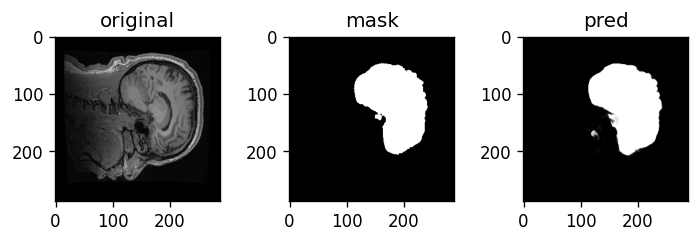

5 , 0 / 500 || Segmenter loss: 0.88 ( 0.04 + 0.84 ) || Discriminator loss: 0.57
5 , 1 / 500 || Segmenter loss: 0.85 ( 0.03 + 0.82 ) || Discriminator loss: 0.57
5 , 2 / 500 || Segmenter loss: 0.82 ( 0.04 + 0.78 ) || Discriminator loss: 0.63
5 , 3 / 500 || Segmenter loss: 0.74 ( 0.04 + 0.71 ) || Discriminator loss: 0.68
5 , 4 / 500 || Segmenter loss: 0.79 ( 0.02 + 0.78 ) || Discriminator loss: 0.66
5 , 5 / 500 || Segmenter loss: 0.82 ( 0.02 + 0.8 ) || Discriminator loss: 0.5
5 , 6 / 500 || Segmenter loss: 0.68 ( 0.03 + 0.65 ) || Discriminator loss: 0.69
5 , 7 / 500 || Segmenter loss: 0.84 ( 0.03 + 0.8 ) || Discriminator loss: 0.57
5 , 8 / 500 || Segmenter loss: 0.65 ( 0.02 + 0.63 ) || Discriminator loss: 0.65
5 , 9 / 500 || Segmenter loss: 0.66 ( 0.03 + 0.62 ) || Discriminator loss: 0.59
5 , 10 / 500 || Segmenter loss: 0.7 ( 0.04 + 0.66 ) || Discriminator loss: 0.62
5 , 11 / 500 || Segmenter loss: 0.68 ( 0.06 + 0.62 ) || Discriminator loss: 0.74
5 , 12 / 500 || Segmenter loss: 0.75 ( 0.0

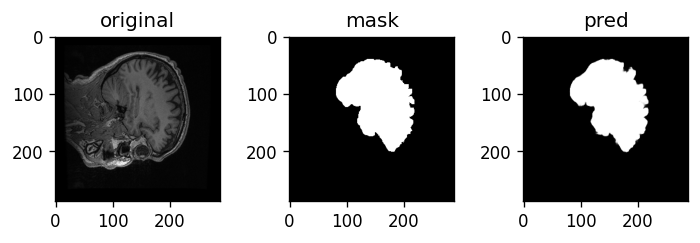

5 , 200 / 500 || Segmenter loss: 0.55 ( 0.03 + 0.53 ) || Discriminator loss: 0.67
5 , 201 / 500 || Segmenter loss: 0.46 ( 0.04 + 0.41 ) || Discriminator loss: 0.78
5 , 202 / 500 || Segmenter loss: 0.45 ( 0.04 + 0.41 ) || Discriminator loss: 0.8
5 , 203 / 500 || Segmenter loss: 0.52 ( 0.03 + 0.49 ) || Discriminator loss: 0.71
5 , 204 / 500 || Segmenter loss: 0.65 ( 0.03 + 0.62 ) || Discriminator loss: 0.61
5 , 205 / 500 || Segmenter loss: 0.55 ( 0.05 + 0.5 ) || Discriminator loss: 0.75
5 , 206 / 500 || Segmenter loss: 0.65 ( 0.05 + 0.6 ) || Discriminator loss: 0.65
5 , 207 / 500 || Segmenter loss: 0.6 ( 0.03 + 0.56 ) || Discriminator loss: 0.69
5 , 208 / 500 || Segmenter loss: 0.64 ( 0.03 + 0.61 ) || Discriminator loss: 0.73
5 , 209 / 500 || Segmenter loss: 0.65 ( 0.03 + 0.62 ) || Discriminator loss: 0.69
5 , 210 / 500 || Segmenter loss: 0.7 ( 0.04 + 0.65 ) || Discriminator loss: 0.66
5 , 211 / 500 || Segmenter loss: 0.7 ( 0.02 + 0.67 ) || Discriminator loss: 0.66
5 , 212 / 500 || Segme

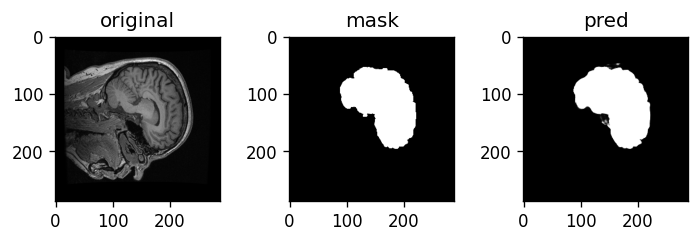

5 , 400 / 500 || Segmenter loss: 0.63 ( 0.03 + 0.61 ) || Discriminator loss: 0.77
5 , 401 / 500 || Segmenter loss: 0.62 ( 0.03 + 0.6 ) || Discriminator loss: 0.72
5 , 402 / 500 || Segmenter loss: 0.64 ( 0.03 + 0.61 ) || Discriminator loss: 0.71
5 , 403 / 500 || Segmenter loss: 0.66 ( 0.03 + 0.63 ) || Discriminator loss: 0.63
5 , 404 / 500 || Segmenter loss: 0.67 ( 0.03 + 0.64 ) || Discriminator loss: 0.63
5 , 405 / 500 || Segmenter loss: 0.68 ( 0.02 + 0.65 ) || Discriminator loss: 0.69
5 , 406 / 500 || Segmenter loss: 0.66 ( 0.04 + 0.63 ) || Discriminator loss: 0.7
5 , 407 / 500 || Segmenter loss: 0.62 ( 0.03 + 0.59 ) || Discriminator loss: 0.68
5 , 408 / 500 || Segmenter loss: 0.7 ( 0.03 + 0.67 ) || Discriminator loss: 0.7
5 , 409 / 500 || Segmenter loss: 0.68 ( 0.04 + 0.64 ) || Discriminator loss: 0.73
5 , 410 / 500 || Segmenter loss: 0.7 ( 0.03 + 0.66 ) || Discriminator loss: 0.65
5 , 411 / 500 || Segmenter loss: 0.69 ( 0.03 + 0.66 ) || Discriminator loss: 0.71
5 , 412 / 500 || Segm

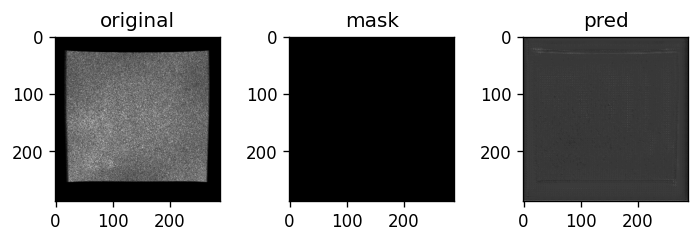

src VAL: 5 , 0 / 135 || Segmenter loss: 1.0 ( 1.0 + 0.0 ) || Discriminator loss: 0.68
src VAL: 5 , 1 / 135 || Segmenter loss: 1.0 ( 1.0 + 0.0 ) || Discriminator loss: 0.7
src VAL: 5 , 2 / 135 || Segmenter loss: 0.08 ( 0.08 + 0.0 ) || Discriminator loss: 0.69
src VAL: 5 , 3 / 135 || Segmenter loss: 0.03 ( 0.03 + 0.0 ) || Discriminator loss: 0.55
src VAL: 5 , 4 / 135 || Segmenter loss: 0.02 ( 0.02 + 0.0 ) || Discriminator loss: 0.42
src VAL: 5 , 5 / 135 || Segmenter loss: 0.03 ( 0.03 + 0.0 ) || Discriminator loss: 0.26
src VAL: 5 , 6 / 135 || Segmenter loss: 0.06 ( 0.06 + 0.0 ) || Discriminator loss: 0.24
src VAL: 5 , 7 / 135 || Segmenter loss: 0.03 ( 0.03 + 0.0 ) || Discriminator loss: 0.15
src VAL: 5 , 8 / 135 || Segmenter loss: 0.02 ( 0.02 + 0.0 ) || Discriminator loss: 0.25
src VAL: 5 , 9 / 135 || Segmenter loss: 0.03 ( 0.03 + 0.0 ) || Discriminator loss: 0.39
src VAL: 5 , 10 / 135 || Segmenter loss: 0.05 ( 0.05 + 0.0 ) || Discriminator loss: 0.66
src VAL: 5 , 11 / 135 || Segmenter l

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

CC0342_ge_3_50_M.nii.gz Surface Dice: 0.9820571260376518 | SD at tol: 0.8989425559670982 | HD: 4.69041575982343


  0%|          | 0/175 [00:00<?, ?it/s]

CC0343_ge_3_54_F.nii.gz Surface Dice: 0.9826117852088424 | SD at tol: 0.9010551549860679 | HD: 3.1622776601683795


  0%|          | 0/199 [00:00<?, ?it/s]

CC0344_ge_3_43_M.nii.gz Surface Dice: 0.9823294915429878 | SD at tol: 0.8611709016334631 | HD: 13.92838827718412


  0%|          | 0/199 [00:00<?, ?it/s]

CC0345_ge_3_53_M.nii.gz Surface Dice: 0.9843260444440479 | SD at tol: 0.9183498311630789 | HD: 2.8284271247461903


  0%|          | 0/199 [00:00<?, ?it/s]

CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9757612213053397 | SD at tol: 0.7887444047510463 | HD: 16.24807680927192


  0%|          | 0/171 [00:00<?, ?it/s]

CC0347_ge_3_52_F.nii.gz Surface Dice: 0.9771607184129044 | SD at tol: 0.8545513625192945 | HD: 7.810249675906654


  0%|          | 0/199 [00:00<?, ?it/s]

CC0348_ge_3_60_F.nii.gz Surface Dice: 0.9831522602996621 | SD at tol: 0.9172002065239954 | HD: 2.23606797749979


  0%|          | 0/199 [00:00<?, ?it/s]

CC0349_ge_3_60_F.nii.gz Surface Dice: 0.9832852790490129 | SD at tol: 0.9179143681029853 | HD: 2.23606797749979


  0%|          | 0/199 [00:00<?, ?it/s]

CC0350_ge_3_62_F.nii.gz Surface Dice: 0.9857827483945102 | SD at tol: 0.9292575899525084 | HD: 2.23606797749979


  0%|          | 0/191 [00:00<?, ?it/s]

CC0351_ge_3_52_M.nii.gz Surface Dice: 0.9833292808756332 | SD at tol: 0.8819036646443245 | HD: 12.36931687685298


  0%|          | 0/199 [00:00<?, ?it/s]

CC0352_ge_3_55_F.nii.gz Surface Dice: 0.9834020643821669 | SD at tol: 0.9088972792095928 | HD: 3.0

ge vol metrics for epoch 5
AVG VOLUMETRIC DICE : 0.9821089109047964 | SD AT TOL: 0.8889079381321323 | HD: 6.43139601058664 #########

######## TRG VAL #########
trg VAL: 5 , 0 / 124 || Segmenter loss: 0.7 ( 0.0 + 0.7 ) || Discriminator loss: 0.69
trg VAL: 5 , 1 / 124 || Segmenter loss: 0.72 ( 0.0 + 0.72 ) || Discriminator loss: 0.67
trg VAL: 5 , 2 / 124 || Segmenter loss: 0.69 ( 0.0 + 0.69 ) || Discriminator loss: 0.7
trg VAL: 5 , 3 / 124 || Segmenter loss: 0.71 ( 0.0 + 0.71 ) || Discriminator loss: 0.68
trg VAL: 5 , 4 / 124 || Segmenter loss: 0.74 ( 0.0 + 0.74 ) || Discriminator loss: 0.65
trg VAL: 5 , 5 / 124 || Segmenter loss: 0.78 ( 0.0 + 0.78 ) || Discriminator loss: 0.61
trg VAL: 5 , 6 / 124 || Segmenter loss: 0.75 ( 0.0 + 0.75 ) || Discriminator loss: 0.64
trg VAL: 5 , 7 / 124 || Segmenter loss: 0.72 ( 0.0 + 0.72 ) || Discriminator loss: 0.66
trg VAL: 5 , 8 / 124 || Segmenter loss

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

CC0102_philips_3_50_M.nii.gz Surface Dice: 0.9474640206373584 | SD at tol: 0.6313232411279259 | HD: 24.08318915758459


  0%|          | 0/179 [00:00<?, ?it/s]

CC0103_philips_3_56_M.nii.gz Surface Dice: 0.9142998033312337 | SD at tol: 0.5929709959361646 | HD: 17.72004514666935


  0%|          | 0/179 [00:00<?, ?it/s]

CC0104_philips_3_34_M.nii.gz Surface Dice: 0.9053449116329999 | SD at tol: 0.44300080732076785 | HD: 54.30469592954186


  0%|          | 0/179 [00:00<?, ?it/s]

CC0105_philips_3_52_M.nii.gz Surface Dice: 0.933052115392525 | SD at tol: 0.6279360681289017 | HD: 18.138357147217054


  0%|          | 0/179 [00:00<?, ?it/s]

CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9239113644356548 | SD at tol: 0.524472444807625 | HD: 28.178005607210743


  0%|          | 0/179 [00:00<?, ?it/s]

CC0107_philips_3_38_M.nii.gz Surface Dice: 0.933181872021049 | SD at tol: 0.6664850514374117 | HD: 18.2208671582886


  0%|          | 0/179 [00:00<?, ?it/s]

CC0108_philips_3_51_M.nii.gz Surface Dice: 0.8562248430805508 | SD at tol: 0.48780946367064904 | HD: 21.540659228538015


  0%|          | 0/179 [00:00<?, ?it/s]

CC0109_philips_3_57_F.nii.gz Surface Dice: 0.9518431296721258 | SD at tol: 0.7221323881885717 | HD: 22.693611435820433


  0%|          | 0/179 [00:00<?, ?it/s]

CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9487804635827358 | SD at tol: 0.6988360501738182 | HD: 23.853720883753127


  0%|          | 0/179 [00:00<?, ?it/s]

CC0111_philips_3_51_M.nii.gz Surface Dice: 0.9103160487351926 | SD at tol: 0.45243886856426047 | HD: 23.0


  0%|          | 0/179 [00:00<?, ?it/s]

CC0112_philips_3_60_M.nii.gz Surface Dice: 0.8795652602794662 | SD at tol: 0.37760524755127656 | HD: 30.822070014844883

philips vol metrics for epoch 5
AVG VOLUMETRIC DICE : 0.918543984800081 | SD AT TOL: 0.5659100569915794 | HD: 25.686838337224422 #########

#########################################################################
EPOCH: 6


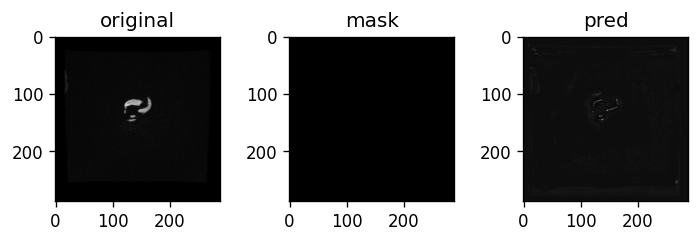

6 , 0 / 500 || Segmenter loss: 0.72 ( 0.03 + 0.69 ) || Discriminator loss: 0.61
6 , 1 / 500 || Segmenter loss: 0.65 ( 0.04 + 0.61 ) || Discriminator loss: 0.6
6 , 2 / 500 || Segmenter loss: 0.6 ( 0.06 + 0.54 ) || Discriminator loss: 0.69
6 , 3 / 500 || Segmenter loss: 0.71 ( 0.04 + 0.66 ) || Discriminator loss: 0.6
6 , 4 / 500 || Segmenter loss: 0.65 ( 0.03 + 0.62 ) || Discriminator loss: 0.67
6 , 5 / 500 || Segmenter loss: 0.69 ( 0.03 + 0.65 ) || Discriminator loss: 0.67
6 , 6 / 500 || Segmenter loss: 0.71 ( 0.04 + 0.67 ) || Discriminator loss: 0.61
6 , 7 / 500 || Segmenter loss: 0.65 ( 0.03 + 0.62 ) || Discriminator loss: 0.69
6 , 8 / 500 || Segmenter loss: 0.69 ( 0.02 + 0.67 ) || Discriminator loss: 0.63
6 , 9 / 500 || Segmenter loss: 0.59 ( 0.03 + 0.56 ) || Discriminator loss: 0.69
6 , 10 / 500 || Segmenter loss: 0.61 ( 0.04 + 0.56 ) || Discriminator loss: 0.68
6 , 11 / 500 || Segmenter loss: 0.7 ( 0.03 + 0.67 ) || Discriminator loss: 0.7
6 , 12 / 500 || Segmenter loss: 0.68 ( 0.04

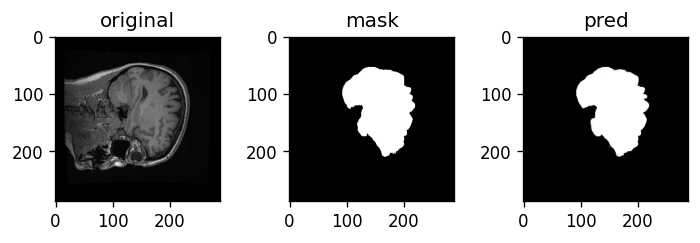

6 , 200 / 500 || Segmenter loss: 0.65 ( 0.03 + 0.62 ) || Discriminator loss: 0.71
6 , 201 / 500 || Segmenter loss: 0.69 ( 0.04 + 0.65 ) || Discriminator loss: 0.62
6 , 202 / 500 || Segmenter loss: 0.68 ( 0.04 + 0.64 ) || Discriminator loss: 0.8
6 , 203 / 500 || Segmenter loss: 0.62 ( 0.03 + 0.59 ) || Discriminator loss: 0.66
6 , 204 / 500 || Segmenter loss: 0.71 ( 0.03 + 0.68 ) || Discriminator loss: 0.62
6 , 205 / 500 || Segmenter loss: 0.64 ( 0.03 + 0.62 ) || Discriminator loss: 0.66
6 , 206 / 500 || Segmenter loss: 0.65 ( 0.02 + 0.63 ) || Discriminator loss: 0.63
6 , 207 / 500 || Segmenter loss: 0.64 ( 0.02 + 0.62 ) || Discriminator loss: 0.74
6 , 208 / 500 || Segmenter loss: 0.68 ( 0.04 + 0.64 ) || Discriminator loss: 0.68
6 , 209 / 500 || Segmenter loss: 0.63 ( 0.03 + 0.61 ) || Discriminator loss: 0.73
6 , 210 / 500 || Segmenter loss: 0.65 ( 0.02 + 0.63 ) || Discriminator loss: 0.67
6 , 211 / 500 || Segmenter loss: 0.65 ( 0.02 + 0.62 ) || Discriminator loss: 0.73
6 , 212 / 500 || 

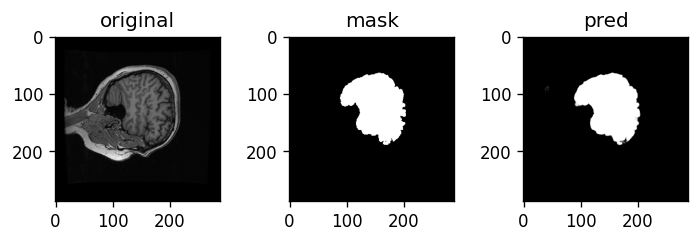

6 , 400 / 500 || Segmenter loss: 0.79 ( 0.02 + 0.76 ) || Discriminator loss: 0.65
6 , 401 / 500 || Segmenter loss: 0.79 ( 0.02 + 0.77 ) || Discriminator loss: 0.65
6 , 402 / 500 || Segmenter loss: 0.9 ( 0.04 + 0.85 ) || Discriminator loss: 0.72
6 , 403 / 500 || Segmenter loss: 0.77 ( 0.02 + 0.76 ) || Discriminator loss: 0.66
6 , 404 / 500 || Segmenter loss: 0.78 ( 0.03 + 0.75 ) || Discriminator loss: 0.66
6 , 405 / 500 || Segmenter loss: 0.76 ( 0.02 + 0.74 ) || Discriminator loss: 0.67
6 , 406 / 500 || Segmenter loss: 0.77 ( 0.04 + 0.73 ) || Discriminator loss: 0.63
6 , 407 / 500 || Segmenter loss: 0.73 ( 0.03 + 0.7 ) || Discriminator loss: 0.67
6 , 408 / 500 || Segmenter loss: 0.72 ( 0.02 + 0.7 ) || Discriminator loss: 0.66
6 , 409 / 500 || Segmenter loss: 0.72 ( 0.03 + 0.69 ) || Discriminator loss: 0.68
6 , 410 / 500 || Segmenter loss: 0.73 ( 0.03 + 0.7 ) || Discriminator loss: 0.64
6 , 411 / 500 || Segmenter loss: 0.71 ( 0.03 + 0.69 ) || Discriminator loss: 0.68
6 , 412 / 500 || Seg

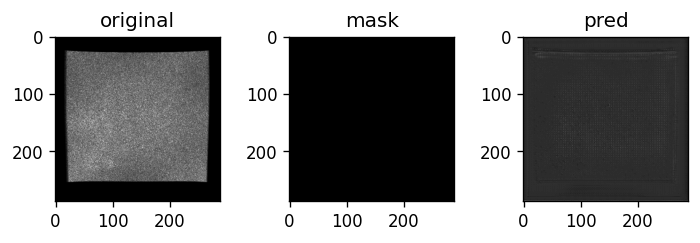

src VAL: 6 , 0 / 135 || Segmenter loss: 1.0 ( 1.0 + 0.0 ) || Discriminator loss: 0.68
src VAL: 6 , 1 / 135 || Segmenter loss: 1.0 ( 1.0 + 0.0 ) || Discriminator loss: 0.68
src VAL: 6 , 2 / 135 || Segmenter loss: 0.06 ( 0.06 + 0.0 ) || Discriminator loss: 0.66
src VAL: 6 , 3 / 135 || Segmenter loss: 0.04 ( 0.04 + 0.0 ) || Discriminator loss: 0.53
src VAL: 6 , 4 / 135 || Segmenter loss: 0.02 ( 0.02 + 0.0 ) || Discriminator loss: 0.36
src VAL: 6 , 5 / 135 || Segmenter loss: 0.03 ( 0.03 + 0.0 ) || Discriminator loss: 0.34
src VAL: 6 , 6 / 135 || Segmenter loss: 0.05 ( 0.05 + 0.0 ) || Discriminator loss: 0.3
src VAL: 6 , 7 / 135 || Segmenter loss: 0.03 ( 0.03 + 0.0 ) || Discriminator loss: 0.24
src VAL: 6 , 8 / 135 || Segmenter loss: 0.02 ( 0.02 + 0.0 ) || Discriminator loss: 0.31
src VAL: 6 , 9 / 135 || Segmenter loss: 0.03 ( 0.03 + 0.0 ) || Discriminator loss: 0.36
src VAL: 6 , 10 / 135 || Segmenter loss: 0.05 ( 0.05 + 0.0 ) || Discriminator loss: 0.64
src VAL: 6 , 11 / 135 || Segmenter l

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

CC0342_ge_3_50_M.nii.gz Surface Dice: 0.9838672912115307 | SD at tol: 0.9195694222308165 | HD: 2.8284271247461903


  0%|          | 0/175 [00:00<?, ?it/s]

CC0343_ge_3_54_F.nii.gz Surface Dice: 0.9861734019917262 | SD at tol: 0.9371368107942083 | HD: 2.0


  0%|          | 0/199 [00:00<?, ?it/s]

CC0344_ge_3_43_M.nii.gz Surface Dice: 0.9834430006427135 | SD at tol: 0.871387584929811 | HD: 10.63014581273465


  0%|          | 0/199 [00:00<?, ?it/s]

CC0345_ge_3_53_M.nii.gz Surface Dice: 0.9850460423215686 | SD at tol: 0.9236319752497799 | HD: 2.449489742783178


  0%|          | 0/199 [00:00<?, ?it/s]

CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9757365655051404 | SD at tol: 0.7921573740916064 | HD: 19.313207915827967


  0%|          | 0/171 [00:00<?, ?it/s]

CC0347_ge_3_52_F.nii.gz Surface Dice: 0.980167681905677 | SD at tol: 0.881483818128504 | HD: 6.4031242374328485


  0%|          | 0/199 [00:00<?, ?it/s]

CC0348_ge_3_60_F.nii.gz Surface Dice: 0.984004975591542 | SD at tol: 0.9264167398542819 | HD: 2.0


  0%|          | 0/199 [00:00<?, ?it/s]

CC0349_ge_3_60_F.nii.gz Surface Dice: 0.9845549080333733 | SD at tol: 0.9271354318048481 | HD: 2.23606797749979


  0%|          | 0/199 [00:00<?, ?it/s]

CC0350_ge_3_62_F.nii.gz Surface Dice: 0.986729992137646 | SD at tol: 0.9442248025813288 | HD: 1.7320508075688772


  0%|          | 0/191 [00:00<?, ?it/s]

CC0351_ge_3_52_M.nii.gz Surface Dice: 0.9822256326145136 | SD at tol: 0.8570569461297031 | HD: 14.142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

CC0352_ge_3_55_F.nii.gz Surface Dice: 0.9791295454687898 | SD at tol: 0.828841785919855 | HD: 17.4928556845359

ge vol metrics for epoch 6
AVG VOLUMETRIC DICE : 0.9828253670385656 | SD AT TOL: 0.8917311537922493 | HD: 7.384318629714578 #########

######## TRG VAL #########
trg VAL: 6 , 0 / 124 || Segmenter loss: 0.68 ( 0.0 + 0.68 ) || Discriminator loss: 0.71
trg VAL: 6 , 1 / 124 || Segmenter loss: 0.67 ( 0.0 + 0.67 ) || Discriminator loss: 0.72
trg VAL: 6 , 2 / 124 || Segmenter loss: 0.65 ( 0.0 + 0.65 ) || Discriminator loss: 0.74
trg VAL: 6 , 3 / 124 || Segmenter loss: 0.7 ( 0.0 + 0.7 ) || Discriminator loss: 0.69
trg VAL: 6 , 4 / 124 || Segmenter loss: 0.69 ( 0.0 + 0.69 ) || Discriminator loss: 0.69
trg VAL: 6 , 5 / 124 || Segmenter loss: 0.71 ( 0.0 + 0.71 ) || Discriminator loss: 0.68
trg VAL: 6 , 6 / 124 || Segmenter loss: 0.69 ( 0.0 + 0.69 ) || Discriminator loss: 0.69
trg VAL: 6 , 7 / 124 || Segmenter loss: 0.69 ( 0.0 + 0.69 ) || Discriminator loss: 0.7
trg VAL: 6 , 8 / 124 || S

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

CC0102_philips_3_50_M.nii.gz Surface Dice: 0.9515807849067429 | SD at tol: 0.6525976804165972 | HD: 23.366642891095847


  0%|          | 0/179 [00:00<?, ?it/s]

CC0103_philips_3_56_M.nii.gz Surface Dice: 0.941206343499486 | SD at tol: 0.6655193835095646 | HD: 17.146428199482248


  0%|          | 0/179 [00:00<?, ?it/s]

CC0104_philips_3_34_M.nii.gz Surface Dice: 0.8969650160893199 | SD at tol: 0.42535102255163815 | HD: 57.0


  0%|          | 0/179 [00:00<?, ?it/s]

CC0105_philips_3_52_M.nii.gz Surface Dice: 0.9404018610349429 | SD at tol: 0.6848158127111516 | HD: 17.4928556845359


  0%|          | 0/179 [00:00<?, ?it/s]

CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9291948638411462 | SD at tol: 0.56275719709289 | HD: 21.494185260204677


  0%|          | 0/179 [00:00<?, ?it/s]

CC0107_philips_3_38_M.nii.gz Surface Dice: 0.940928630457579 | SD at tol: 0.6811738052357216 | HD: 18.027756377319946


  0%|          | 0/179 [00:00<?, ?it/s]

CC0108_philips_3_51_M.nii.gz Surface Dice: 0.885033369964565 | SD at tol: 0.5643658585661473 | HD: 21.77154105707724


  0%|          | 0/179 [00:00<?, ?it/s]

CC0109_philips_3_57_F.nii.gz Surface Dice: 0.9563356280975004 | SD at tol: 0.755263825209734 | HD: 20.09975124224178


  0%|          | 0/179 [00:00<?, ?it/s]

CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9442095124106838 | SD at tol: 0.6745165424436428 | HD: 29.189039038652847


  0%|          | 0/179 [00:00<?, ?it/s]

CC0111_philips_3_51_M.nii.gz Surface Dice: 0.9159437256706152 | SD at tol: 0.47778292015273893 | HD: 21.79449471770337


  0%|          | 0/179 [00:00<?, ?it/s]

CC0112_philips_3_60_M.nii.gz Surface Dice: 0.8890047842903517 | SD at tol: 0.4091700437359789 | HD: 30.675723300355934

philips vol metrics for epoch 6
AVG VOLUMETRIC DICE : 0.9264367745693576 | SD AT TOL: 0.5957558265114368 | HD: 25.27803797896998 #########

#########################################################################
EPOCH: 7


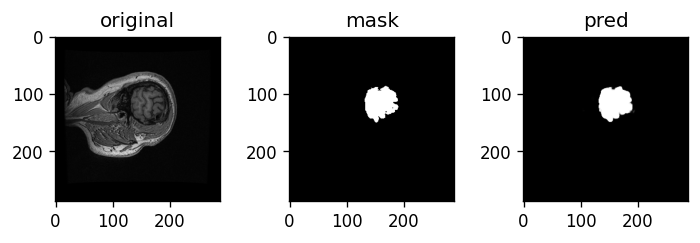

7 , 0 / 500 || Segmenter loss: 0.68 ( 0.04 + 0.64 ) || Discriminator loss: 0.69
7 , 1 / 500 || Segmenter loss: 0.71 ( 0.03 + 0.69 ) || Discriminator loss: 0.63


KeyboardInterrupt: ignored

In [51]:

# VALIDATE AND CHECK VOLUMETRIC SCORES ONCE BEFORE TRAINING 
# n = -1 #BEFORE 0-th epoch

# '''
# SRC EVAL BEFORE TRAINING
# '''
# print()
# print("######## SRC VAL #########")
# src_val_stats = validation(n, segmenter, discriminator, src_val_loader, "src", src_val_stats)

# print()
# src_val_stats = Eval_Vol_Dice('ge', 'val', segmenter, src_val_stats, n)


# '''
# TRG EVAL BEFORE TRAINING
# '''
# print()
# print('######## TRG VAL #########')
# trg_val_stats = validation(n, segmenter, discriminator, trg_val_loader, "trg", trg_val_stats)

# print()
# trg_val_stats  = Eval_Vol_Dice('philips', 'val', segmenter, trg_val_stats, n)


'''
BEGIN TRAINING
'''
no_of_epochs = 7
for n in range(5, no_of_epochs):

  print()
  print("#########################################################################")
  print("EPOCH:",n)

  train_stats, segmenter, discriminator, seg_opt, disc_opt = train(n, seg_opt, disc_opt, segmenter, discriminator, train_loader, train_stats)
  

  '''
  SRC EVAL DURING TRAINING
  '''
  print()
  print("######## SRC VAL #########")
  src_val_stats = validation(n, segmenter, discriminator, src_val_loader, "src", src_val_stats)

  print()
  src_val_stats = Eval_Vol_Dice('ge', 'val', segmenter, src_val_stats, n)


  '''
  TRG EVAL DURING TRAINING
  '''
  print()
  print('######## TRG VAL #########')
  trg_val_stats = validation(n, segmenter, discriminator, trg_val_loader, "trg", trg_val_stats)

  print()
  trg_val_stats  = Eval_Vol_Dice('philips', 'val', segmenter, trg_val_stats, n)



In [ ]:
# torch.save(segmenter,'/content/gdrive/MyDrive/VMIA_Lab_Data/GE3/ge3_adv_seg_2ep.pkl' )
# torch.save(discriminator,'/content/gdrive/MyDrive/VMIA_Lab_Data/GE3/ge3_adv_disc_2ep.pkl' )

In [52]:
no_of_epochs = 7

In [55]:
#################################
# CHANGE DETAILS BEFORE SAVING  #
#################################

import os

base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/Plots/Adversarial_training/'
folder  = 'Exp2_extended/'
os.mkdir(base_path + folder)

file1 = open(base_path + folder + "Description.txt","a")
file1.writelines(['Pre-trained disc with lower learning rate \n',
                  'Disc lr: 1e-4 \n',
                  'Seg lr: 1e-5 \n',
                  'Trained for 2 more epochs i.e until epoch 7'
                  ])
file1.close()


In [60]:
n = no_of_epochs
print(n)

file_name= base_path + folder + '/train_stats_'+str(n)+'epochs.pkl'
f = open(file_name,'wb')
pickle.dump(train_stats,f)
f.close()

file_name= base_path + folder + '/src_val_stats_'+str(n)+'epochs.pkl'
f = open(file_name,'wb')
pickle.dump(src_val_stats,f)
f.close()

file_name= base_path + folder + '/trg_val_stats_'+str(n)+'epochs.pkl'
f = open(file_name,'wb')
pickle.dump(trg_val_stats,f)
f.close()


7


In [61]:
torch.save(segmenter,base_path + folder +'/ge3_adv_segmodel_'+str(n)+'epochs.pkl' )
torch.save(discriminator,base_path + folder +'/ge3_adv_discmodel_'+str(n)+'epochs.pkl' )

# Plots

In [71]:
def plot_acc(stats_dict, start_epoch, end_epoch, path):
    
    a_acc = []; d_acc = []; ds_acc = []; dt_acc = [];
    
    for n in range(start_epoch,end_epoch):
        a_acc.append( stats_dict['adv_acc'][n] )
        d_acc.append( stats_dict['disc_acc'][n] )
        ds_acc.append( stats_dict['disc_src_acc'][n] )
        dt_acc.append( stats_dict['disc_trg_acc'][n] )
    
    
    fig, axs = plt.subplots(2, 2 , sharey = True)
    fig.set_size_inches(8, 8)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Plots for avg accuracy per training epoch', fontsize=16)
    
    
    axs[0,0].plot(a_acc)
    axs[0, 0].set_title("Adversarial Acc.")
    axs[0, 0].set_xlabel("no. of epochs")
    axs[0, 0].set_ylabel("Accuracy")
    
    axs[0,1].plot(d_acc)
    axs[0, 1].set_title("Disc Acc.")
    axs[0, 1].set_xlabel("no. of epochs")
    axs[0, 1].set_ylabel("Accuracy")
    
    axs[1, 0].plot(ds_acc)
    axs[1, 0].set_title("Disc. Source Acc.")
    axs[1, 0].set_xlabel("no. of epochs")
    axs[1, 0].set_ylabel("Accuracy")
    
    axs[1, 1].plot(dt_acc)
    axs[1, 1].set_title("Disc. Target Acc.")
    axs[1, 1].set_xlabel("no. of epochs")
    axs[1, 1].set_ylabel("Accuracy")
    plt.pause(0.01)

    fig.savefig(path + '/train_acc')

##########################################################################

def plot_mean_losses(stats_dict,start_epoch, end_epoch, domain, path):
    
    cl_mean = []; sl_mean = []; dl_mean = []; al_mean = [];
    
    for n in range(start_epoch, end_epoch):
        cl_mean.append( mean(stats_dict['combined_loss'][n] ))
        sl_mean.append( mean(stats_dict['seg_loss'][n] ))
        dl_mean.append( mean(stats_dict['disc_loss'][n] ))
        al_mean.append( mean(stats_dict['adv_loss'][n] ))
    
   
    fig, axs = plt.subplots(2, 2, sharey = True)
    fig.set_size_inches(8, 8)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Plots for mean loss per '+domain+' epoch', fontsize=16)

    
    axs[0,0].plot(dl_mean)
    axs[0, 0].set_title("Discriminator Loss")
    axs[0, 0].set_xlabel("no. of epochs")
    axs[0, 0].set_ylabel("BCE Loss")
    
    axs[0,1].plot(cl_mean)
    axs[0, 1].set_title("Combined Loss")
    axs[0, 1].set_xlabel("no. of epochs")
    axs[0, 1].set_ylabel("Dice-BCE + BCE Loss")
    
    axs[1, 0].plot(sl_mean)
    axs[1, 0].set_title("Segmenter Loss")
    axs[1, 0].set_xlabel("no. of epochs")
    axs[1, 0].set_ylabel("Dice-BCE Loss")
    
    axs[1, 1].plot(al_mean)
    axs[1, 1].set_title("Adversarial Loss")
    axs[1, 1].set_xlabel("no. of epochs")
    axs[1, 1].set_ylabel("BCE Loss")
    plt.pause(0.01)

    fig.savefig(path + '/mean_losses_'+domain)

##########################################################################

def plot_iter_losses(stats_dict, start_epoch, end_epoch,domain, path):
    
    c_loss = []; s_loss = []; d_loss = []; a_loss = [];
    
    for n in range(start_epoch, end_epoch):
        c_loss.extend(stats_dict['combined_loss'][n])
        s_loss.extend(stats_dict['seg_loss'][n])
        d_loss.extend(stats_dict['disc_loss'][n])
        a_loss.extend(stats_dict['adv_loss'][n])
    
    fig, axs = plt.subplots(2, 2,  sharey = True)
    fig.set_size_inches(8, 8)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Plots for loss for all '+domain+' iterations', fontsize=16)

    
    axs[0,0].plot(d_loss)
    axs[0, 0].set_title("Discriminator Loss")
    axs[0, 0].set_xlabel("no. of iters")
    axs[0, 0].set_ylabel("BCE Loss")
    
    axs[0,1].plot(c_loss)
    axs[0, 1].set_title("Combined Loss")
    axs[0, 1].set_xlabel("no. of iters")
    axs[0, 1].set_ylabel("Dice-BCE(seg) + BCE(disc) Loss")
    
    axs[1, 0].plot(s_loss)
    axs[1, 0].set_title("Segmenter Loss")
    axs[1, 0].set_xlabel("no. of iters")
    axs[1, 0].set_ylabel("Dice-BCE Loss")
    
    axs[1, 1].plot(a_loss)
    axs[1, 1].set_title("Adversarial Loss")
    axs[1, 1].set_xlabel("no. of iters")
    axs[1, 1].set_ylabel("BCE Loss")
    plt.pause(0.01)
    
    fig.savefig(path + '/iter_losses_'+domain)
#############################################################################

def plot_avg_dice_scores(stats_dict, start_epoch, end_epoch, mode, domain, path):
    
    if mode == "train":
    
        s_dice = list(); t_dice = list()
        
        for n in range(start_epoch,end_epoch):
            s_dice.append( stats_dict['avg_src_dice'][n] )
            t_dice.append( stats_dict['avg_trg_dice'][n] )
            
        fig, axs = plt.subplots(1, 1, sharey = True)
        fig.set_size_inches(7, 4)
        fig.tight_layout(pad=3.5)
        fig.suptitle('Avg dice scores per training epoch', fontsize=16)

        axs.plot(s_dice, label = 'src')
        #axs.set_title("Source Dice")
        axs.plot(t_dice, label = 'trg')
        #axs.set_title("Target Dice")
        
        axs.set_xlabel("no. of epochs")
        axs.set_ylabel("Avg Dice Scores")
        
        plt.legend()

        fig.savefig(path + '/avg_dice_'+mode+'_'+domain)
    
    elif mode == "val":
        
        v_dice = list();
        
        for n in range(start_epoch,end_epoch):
            v_dice.append( stats_dict['avg_dice_score'][n] )
        
        fig, axs = plt.subplots(1, 1 , sharey = True)
        fig.set_size_inches(8, 4)
        fig.tight_layout(pad=3.5)
        fig.suptitle('Avg dice scores per '+domain+' validation epoch', fontsize=16)

        axs.plot(v_dice, label = domain)
        #axs.set_title("Dice Score for "+domain)
        axs.set_xlabel("no. of epochs")
        axs.set_ylabel("Avg Dice Score")
        
        plt.legend()

        fig.savefig(path + '/avg_dice_'+mode+'_'+domain)
############################################################

def plot_val_acc(stats_dict, start_epoch, end_epoch, domain, path):
    
    a_acc = []; d_acc = [];
    
    for n in range(start_epoch,end_epoch):
        a_acc.append( stats_dict['adv_acc'][n] )
        d_acc.append( stats_dict['disc_acc'][n] )
    
    
    if domain == 'source':
        
        fig, axs = plt.subplots(1, 1 , sharey = True)
        fig.set_size_inches(5, 5)
        fig.tight_layout(pad=5.0)
        fig.suptitle('Avg accuracy per '+ domain +' validation epoch', fontsize=16)


        #axs[0].plot(a_acc)
        #axs[0].set_title("Adversarial Acc.")
        #axs[0].set_xlabel("no. of epochs")
        #axs[0].set_ylabel("Accuracy")

        axs.plot(d_acc)
        axs.set_title("Disc Acc.")
        axs.set_xlabel("no. of epochs")
        axs.set_ylabel("Accuracy")

        fig.savefig(path + '/val_acc_'+domain)
        
    elif domain == 'target':
        
        fig, axs = plt.subplots(1, 1 , sharey = True)
        fig.set_size_inches(7, 5)
        fig.tight_layout(pad=5.0)
        fig.suptitle('Avg accuracy '+ domain +' validation epoch', fontsize=16)


        axs.plot(a_acc, label = 'adv')
        axs.set_title("Adversarial Acc.")
        axs.set_xlabel("no. of epochs")
        axs.set_ylabel("Accuracy")

        axs.plot(d_acc, label = 'disc')
        axs.set_title("Disc Acc.")
        axs.set_xlabel("no. of epochs")
        axs.set_ylabel("Accuracy")
        
        plt.legend()
        fig.savefig(path + '/val_acc_'+domain)
         
       
    plt.pause(0.01)


################################################################################

def plot_volumetric_val(stats_dict, start_epoch, end_epoch, domain, path):
    dice = []; sdat = []; hd = []; 

    if domain == 'source':
      dom = 'src'
    elif domain == 'target':
      dom = 'trg'
    
    for n in range(start_epoch, end_epoch):
        dice.append(  mean(stats_dict[dom+'_val_vol_dice'][n]) )
        sdat.append( mean(stats_dict[dom+'_val_vol_sdat'][n]) )
        hd.append( mean(stats_dict[dom+'_val_vol_hd'][n]) )
        
    fig, axs = plt.subplots(1, 2,  sharey = True)
    fig.set_size_inches(8, 5)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Volume metrics for '+domain+' validation', fontsize=16)
    
    axs[0].plot(dice)
    axs[0].set_title("Dice Score")
    axs[0].set_xlabel('no. of epochs')
    axs[0].set_ylabel("Dice Score")
    
    axs[1].plot(sdat)
    axs[1].set_title("Surface Dice")
    axs[1].set_xlabel('no. of epochs')
    axs[1].set_ylabel("Surface Dice at 1mm tolerance")
    
    plt.pause(0.01)
    
    fig.savefig(path + '/volumetric_scores_'+domain)

    plt.plot(hd)
    plt.title('Volumetric Hausdorff distance for '+domain+' validation')
    plt.xlabel('no. of epochs')
    plt.ylabel('Hausdorff distance')

    plt.savefig(path+'/volumetric_hausdorff_dist_'+domain)
    

## Training

In [72]:
def training_plots(train_stats, end_epoch, path):
  
  n_epochs = end_epoch 

  plot_acc(train_stats, 0, n_epochs, path)

  plot_mean_losses(train_stats, 0, n_epochs, 'train', path)

  plot_iter_losses(train_stats, 0, n_epochs, 'train', path)

  plot_avg_dice_scores(train_stats, 0, n_epochs, "train", "train", path)

In [73]:

file_name = 'train_stats_'+str(n)+'epochs.pkl'

with open(base_path + folder + file_name, 'rb') as f:
    train_stats = pickle.load(f)

7


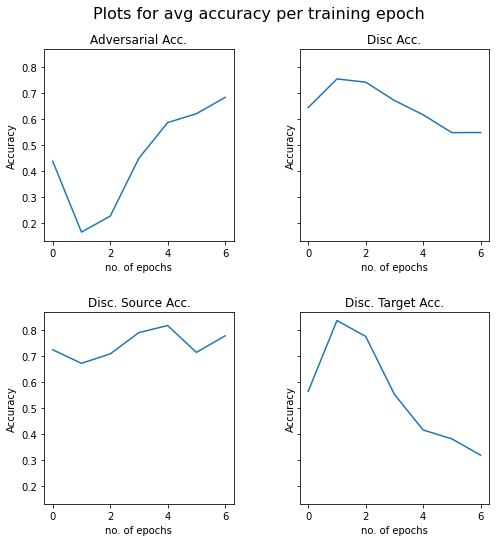

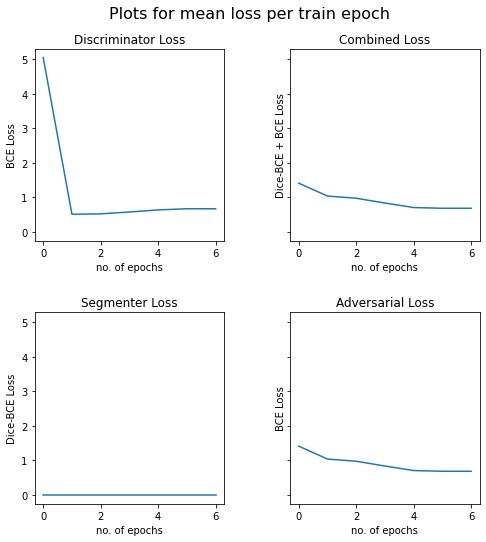

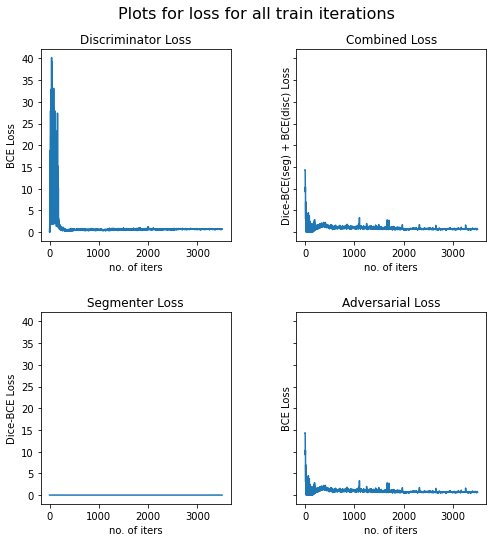

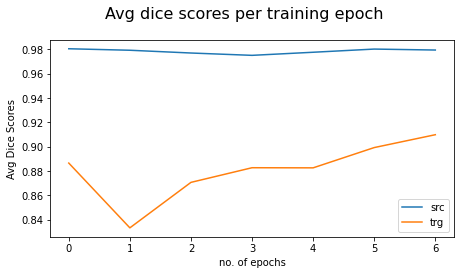

In [74]:
print(no_of_epochs)
training_plots(train_stats, no_of_epochs, base_path + folder)

## Val

In [75]:
def validation_plotting(val_stats, start_epoch, end_epoch, domain, path):

  n_epochs = end_epoch 

  plot_mean_losses(val_stats, start_epoch, n_epochs, domain + ' val', path)

  plot_iter_losses(val_stats, start_epoch, n_epochs, domain + ' val', path)

  plot_val_acc(val_stats, start_epoch, n_epochs, domain, path)

  plot_avg_dice_scores( val_stats, start_epoch, n_epochs, "val", domain, path)

  plot_volumetric_val( val_stats, start_epoch, n_epochs, domain, path)

### Src Val

In [76]:

file_name = 'src_val_stats_'+str(n)+'epochs.pkl'

with open(base_path + folder + file_name, 'rb') as f:
    src_val_stats = pickle.load(f)

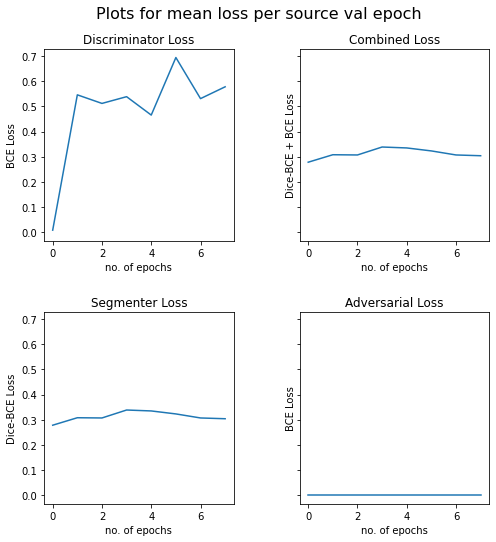

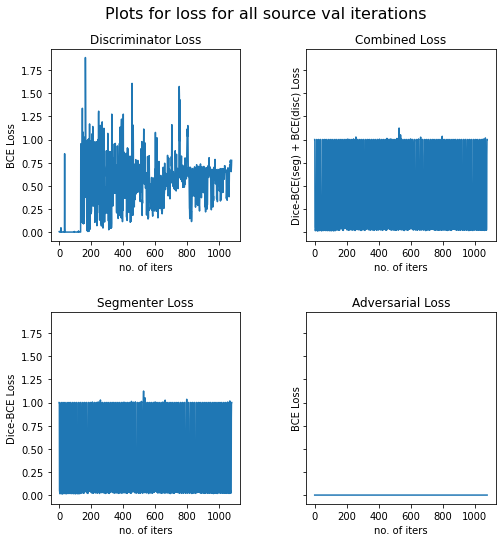

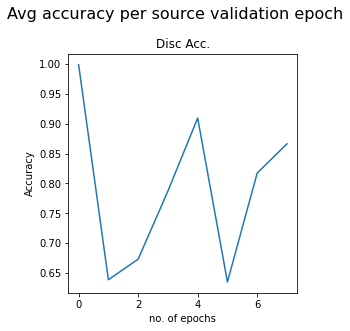

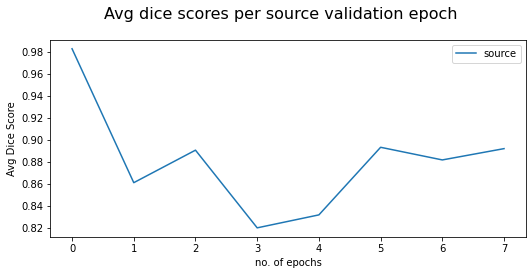

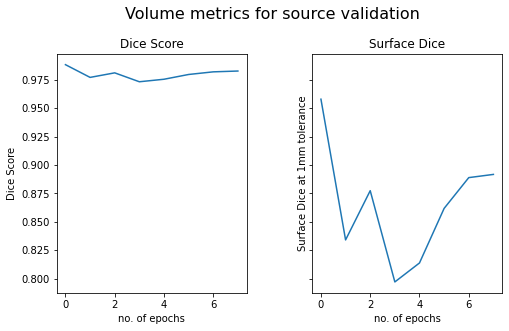

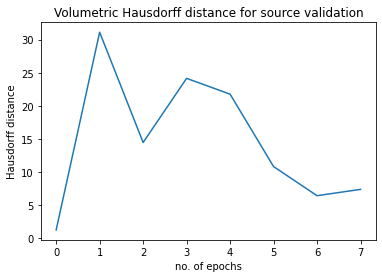

In [77]:
validation_plotting(src_val_stats, -1, no_of_epochs, 'source', base_path + folder)

### Trg Val

In [78]:

file_name = 'trg_val_stats_'+str(n)+'epochs.pkl'

with open(base_path + folder + file_name, 'rb') as f:
    trg_val_stats = pickle.load(f)

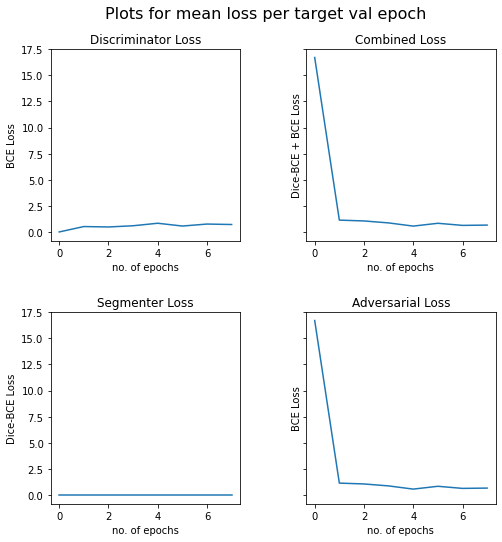

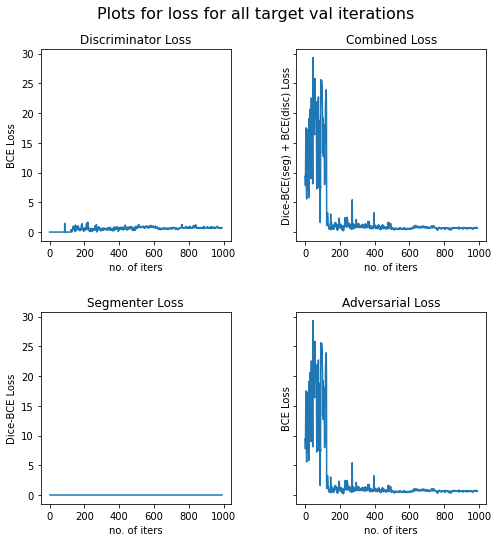

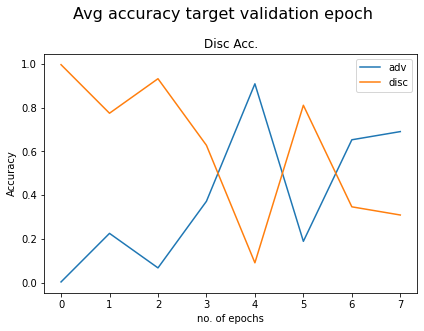

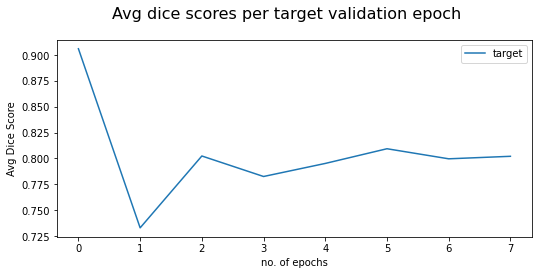

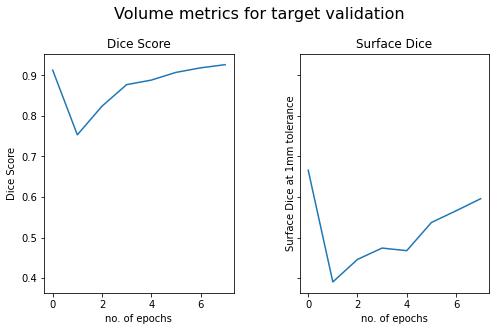

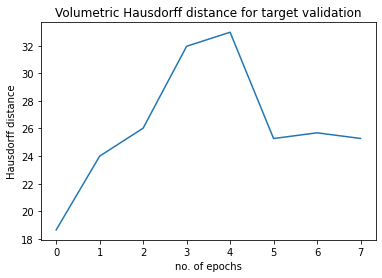

In [79]:
validation_plotting(trg_val_stats, -1, no_of_epochs, 'target', base_path + folder)

## Combined plots

In [13]:
def cplot_train_losses(stats_dict,start_epoch, end_epoch, path):
    
    cl_mean = []; sl_mean = []; dl_mean = []; al_mean = [];
    
    for n in range(start_epoch, end_epoch):
        cl_mean.append( mean(stats_dict['combined_loss'][n] ))
        sl_mean.append( mean(stats_dict['seg_loss'][n] ))
        dl_mean.append( mean(stats_dict['disc_loss'][n] ))
        al_mean.append( mean(stats_dict['adv_loss'][n] ))
    
    fig, axs = plt.subplots(1, 1, sharey = True )
    fig.set_size_inches(4, 4)
    fig.tight_layout(pad=3.0)
    
    fig.suptitle('Training Loss (avg. per epoch)', fontsize=16)
    
    
    axs.plot(dl_mean, label = 'discriminator')
    axs.plot(cl_mean, label = 'combined (seg + adv)')
    axs.plot(sl_mean, label = 'segmenter')
    axs.plot(al_mean, label = 'adversarial')
    axs.hlines(0.75,start_epoch,end_epoch-1, linestyles = 'dashed', label = 'convergence (0.75)')
    axs.set_xlabel("no. of epochs")
    axs.set_ylabel("Loss")
    axs.legend()
    
    fig.savefig(path + 'training_losses.png', dpi= 300)
    
    plt.pause(0.01)
    
def cplot_train_acc(stats_dict, start_epoch, end_epoch, path):
    
    a_acc = []; d_acc = []; ds_acc = []; dt_acc = [];
    
    for n in range(start_epoch,end_epoch):
        a_acc.append( stats_dict['adv_acc'][n] )
        d_acc.append( stats_dict['disc_acc'][n] )
        ds_acc.append( stats_dict['disc_src_acc'][n] )
        dt_acc.append( stats_dict['disc_trg_acc'][n] )
    
    fig, axs = plt.subplots(1, 2, sharey = True )
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Train accuracy (avg. per epoch)', fontsize=16)
    
     
    axs[0].plot(a_acc, label = 'adversarial')
    axs[0].plot(d_acc, label = 'discriminator')
    axs[0].set_title("Adversarial and Discriminator Acc.")
    axs[0].set_xlabel("no. of epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    
    axs[1].plot(ds_acc, label = 'disc source')
    axs[1].plot(dt_acc, label = 'disc target')
    axs[1].plot(d_acc, label = 'discriminator', linestyle = 'dashed')
    axs[1].set_title("Discriminator Acc. split")    
    axs[1].set_xlabel("no. of epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    
    fig.savefig(path + 'training_acc.png', dpi=300)
    
    
    plt.pause(0.01)


def cplot_val_losses(src_stats_dict, trg_stats_dict, start_epoch, end_epoch, path):
    
    s_cl_mean = []; s_sl_mean = []; s_dl_mean = [];
    t_cl_mean = []; t_sl_mean = []; t_dl_mean = []; t_al_mean = [];
    
    for n in range(start_epoch, end_epoch):
        #s_cl_mean.append( mean(src_stats_dict['combined_loss'][n] ))
        s_sl_mean.append( mean(src_stats_dict['seg_loss'][n] ))
        s_dl_mean.append( mean(src_stats_dict['disc_loss'][n] ))
        
        t_cl_mean.append( mean(trg_stats_dict['combined_loss'][n] ))
        t_sl_mean.append( mean(trg_stats_dict['seg_loss'][n] ))
        t_dl_mean.append( mean(trg_stats_dict['disc_loss'][n] ))
        t_al_mean.append( mean(trg_stats_dict['adv_loss'][n] ))
    
    
    fig, axs = plt.subplots(1, 2, sharey = False )
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Validation loss (avg. per epoch)', fontsize=16)
    
    axs[0].set_title("Source Val")
    axs[0].plot(s_dl_mean, label = 'discriminator')
    #axs[0].plot(s_cl_mean, label = 'combined (seg + adv)')
    axs[0].plot(s_sl_mean, label = 'segmenter')
    axs[0].set_xlabel("no. of epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    
    axs[1].set_title("Target Val")
    axs[1].plot(t_dl_mean, label = 'discriminator')
    axs[1].plot(t_cl_mean, label = 'combined (seg + adv)')
    axs[1].plot(t_sl_mean, label = 'segmenter')
    axs[1].plot(t_al_mean, label = 'adversarial')
    axs[1].hlines(0.75,0,6, linestyles = 'dashed', label = 'convergence (0.75)')
    axs[1].set_xlabel("no. of epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    
    #plt.hlines(0.75,0,6, linestyles = 'dashed', label = 'convergence (0.75)')
    
    fig.savefig(path + 'val_losses.png', dpi=300)
    
    
    plt.pause(0.01)


def cplot_val_acc(src_stats_dict, trg_stats_dict, start_epoch, end_epoch, path):
    
    t_a_acc = []; t_d_acc = []; s_d_acc = [];
    
    for n in range(start_epoch,end_epoch): 
        
        s_d_acc.append( src_stats_dict['disc_acc'][n] )
        
        t_a_acc.append( trg_stats_dict['adv_acc'][n] )
        t_d_acc.append( trg_stats_dict['disc_acc'][n])
    
    
    fig, axs = plt.subplots(1, 2 , sharey = True)
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Validation accuracy (avg. per epoch)', fontsize=16)


    #axs[0].plot(a_acc)
    #axs[0].set_title("Adversarial Acc.")
    #axs[0].set_xlabel("no. of epochs")
    #axs[0].set_ylabel("Accuracy")
    
    axs[0].plot(s_d_acc, label = "disc acc src val")
    axs[0].set_title("Source val accuracy")
    axs[0].set_xlabel("no. of epochs")
    axs[0].set_ylabel("Accuracy")
    
    
    axs[1].plot(t_d_acc, label = "disc acc target val")    
    axs[1].plot(t_a_acc, label = "adv acc target val")
    axs[1].set_title("Target val accuracies")
    
    axs[1].set_xlabel("no. of epochs")
    axs[1].set_ylabel("Accuracy")
    
    axs[0].legend(loc = 'lower right')
    axs[1].legend(loc = 'lower right')
    
    fig.savefig(path + 'val_acc.png', dpi=300)



def cplot_volumetric_val(src_stats_dict, trg_stats_dict, start_epoch, end_epoch, path):
    s_dice = []; s_sdat = []; s_hd = []; 
    t_dice = []; t_sdat = []; t_hd = [];
    
    
    for n in range(start_epoch, end_epoch):
        s_dice.append(  mean(src_stats_dict['src_val_vol_dice'][n]) )
        s_sdat.append( mean(src_stats_dict['src_val_vol_sdat'][n]) )
        s_hd.append( mean(src_stats_dict['src_val_vol_hd'][n]) )
        
        t_dice.append(  mean(trg_stats_dict['trg_val_vol_dice'][n]) )
        t_sdat.append( mean(trg_stats_dict['trg_val_vol_sdat'][n]) )
        t_hd.append( mean(trg_stats_dict['trg_val_vol_hd'][n]) )
        
    fig, axs = plt.subplots(1, 3,  sharey = False)
    fig.set_size_inches(12, 4)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Validation volume metrics (avg. per epoch)' , fontsize=16)
    
    axs[0].plot(s_dice, label = "src val dice")
    axs[0].plot(t_dice, label = "trg val dice")
    axs[0].set_title("Avg. Volumetric Dice Scores")
    axs[0].set_xlabel('no. of epochs')
    axs[0].set_ylabel("Volumetric Dice Score")
    axs[0].legend()
    
    axs[1].plot(s_sdat, label = "src val surf. dice")
    axs[1].plot(t_sdat, label = "trg val surf. dice")
    axs[1].set_title("Avg. Surface Dice (1mm tolerance)")
    axs[1].set_xlabel('no. of epochs')
    axs[1].set_ylabel("Surface Dice 1mm tol")
    axs[1].legend()
    
    
    axs[2].plot(s_hd, label= 'src val haus. dist')
    axs[2].plot(t_hd, label= 'trg val haus. dist')
    axs[2].set_title("Avg. Hausdorff distance")
    axs[2].set_xlabel('no. of epochs')
    axs[2].set_ylabel('Hausdorff distance')
    axs[2].legend()
    
    fig.savefig(path + 'val_volumetric.png', dpi= 300)
    
    
    plt.pause(0.01)
    

In [11]:
# base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/Plots/Adversarial_training/'
# folder  = 'Exp2_extended/'
# n = 7
file_name = 'train_stats_'+str(n)+'epochs.pkl'
with open(base_path + folder + file_name, 'rb') as f:
    train_stats = pickle.load(f)

file_name = 'src_val_stats_'+str(n)+'epochs.pkl'
with open(base_path + folder + file_name, 'rb') as f:
    src_val_stats = pickle.load(f)

file_name = 'trg_val_stats_'+str(n)+'epochs.pkl'
with open(base_path + folder + file_name, 'rb') as f:
    trg_val_stats = pickle.load(f)

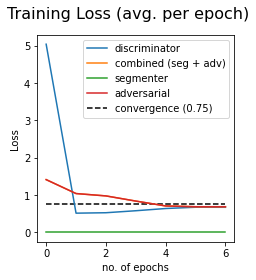

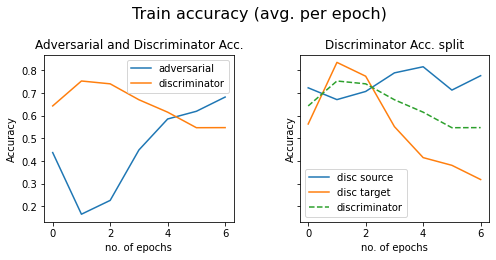

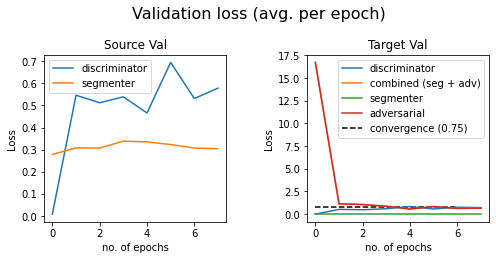

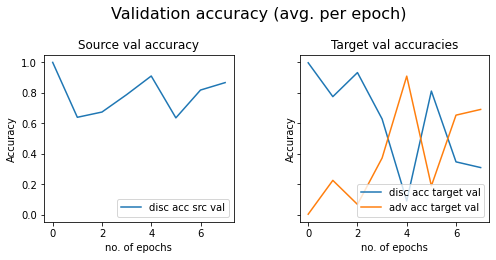

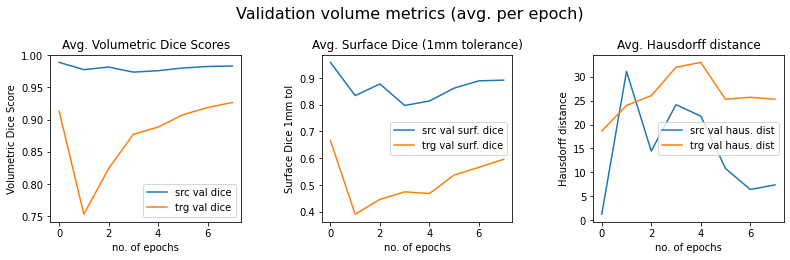

In [14]:

path = base_path + folder

start_epoch = 0
end_epoch = 7
cplot_train_losses(train_stats,start_epoch, end_epoch, path)
cplot_train_acc(train_stats, start_epoch, end_epoch, path)

start_epoch = -1
end_epoch = 7
cplot_val_losses(src_val_stats, trg_val_stats, start_epoch, end_epoch, path)
cplot_val_acc(src_val_stats, trg_val_stats, start_epoch, end_epoch, path)
cplot_volumetric_val(src_val_stats, trg_val_stats, start_epoch, end_epoch, path)